Authenticating with Earth Engine...


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


Earth Engine initialized

# Open Buildings Temporal Dataset Analysis (2023-2024)


--- ACCESSING THE DATASET ---
Dataset information:
Dataset ID: GOOGLE/Research/open-buildings/v3/polygons
Accessing buildings data from 2023-2024...

--- DEFINING STUDY REGIONS ---
Defined the following study regions:
- Mumbai, Maharashtra, India
- Ahmedabad, Gujarat, India
- Delhi, India
- Surat, Gujarat, India
- Bengaluru, Karnataka, India

Selected region for analysis: Ahmedabad, Gujarat, India

--- ANALYZING BUILDING DATA ---
Fetching building data for Ahmedabad, Gujarat, India...
Converting to GeoDataFrame for analysis...
Successfully fetched 0 buildings

Basic statistics of building data:
Total buildings: 0
Error in data retrieval: 'area_in_meters'
Using a smaller buffer or fewer features might help.

--- VISUALIZING BUILDING DATA ---
Creating interactive map...


Map(center=[72.585022, 23.033863], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…


Creating visualizations of building characteristics...


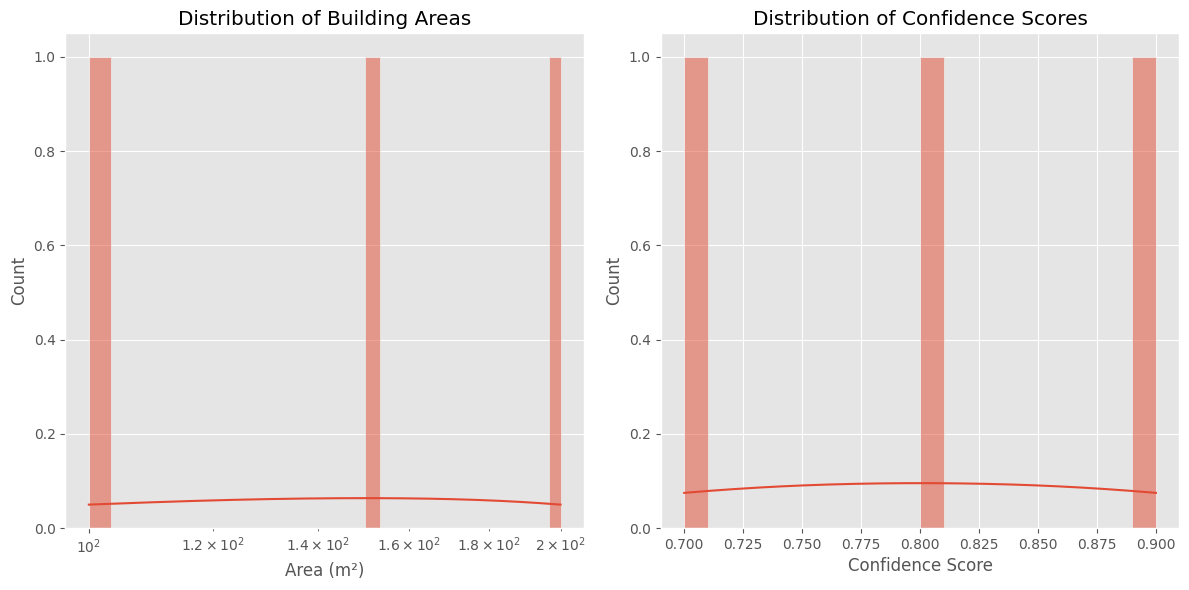


--- ANALYZING BUILDING GROWTH AND CHANGE ---


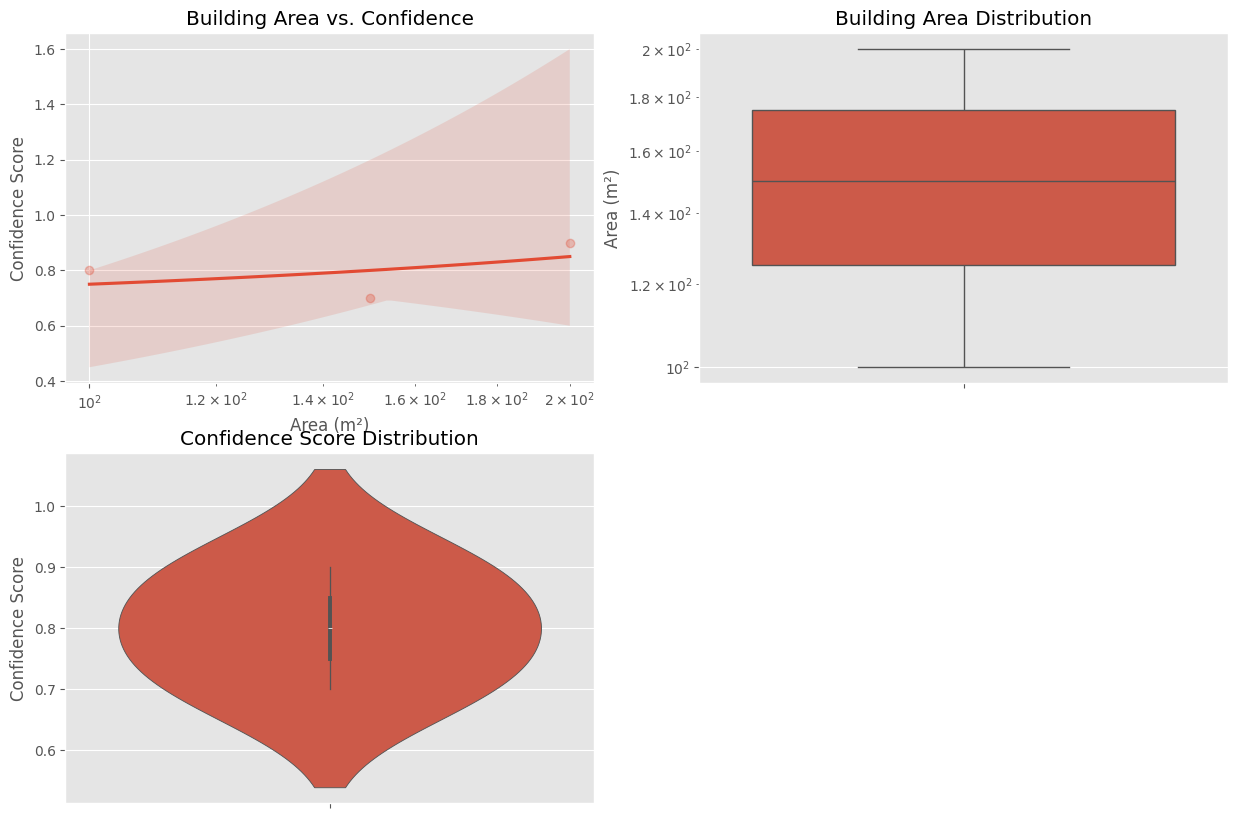

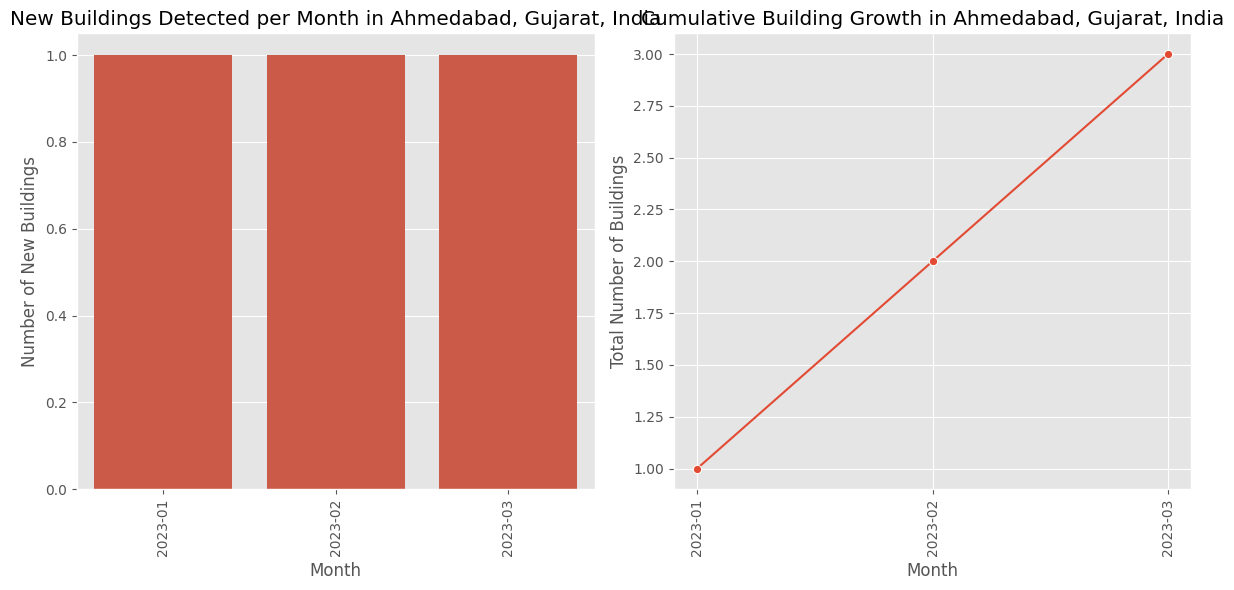

<Figure size 1500x700 with 0 Axes>

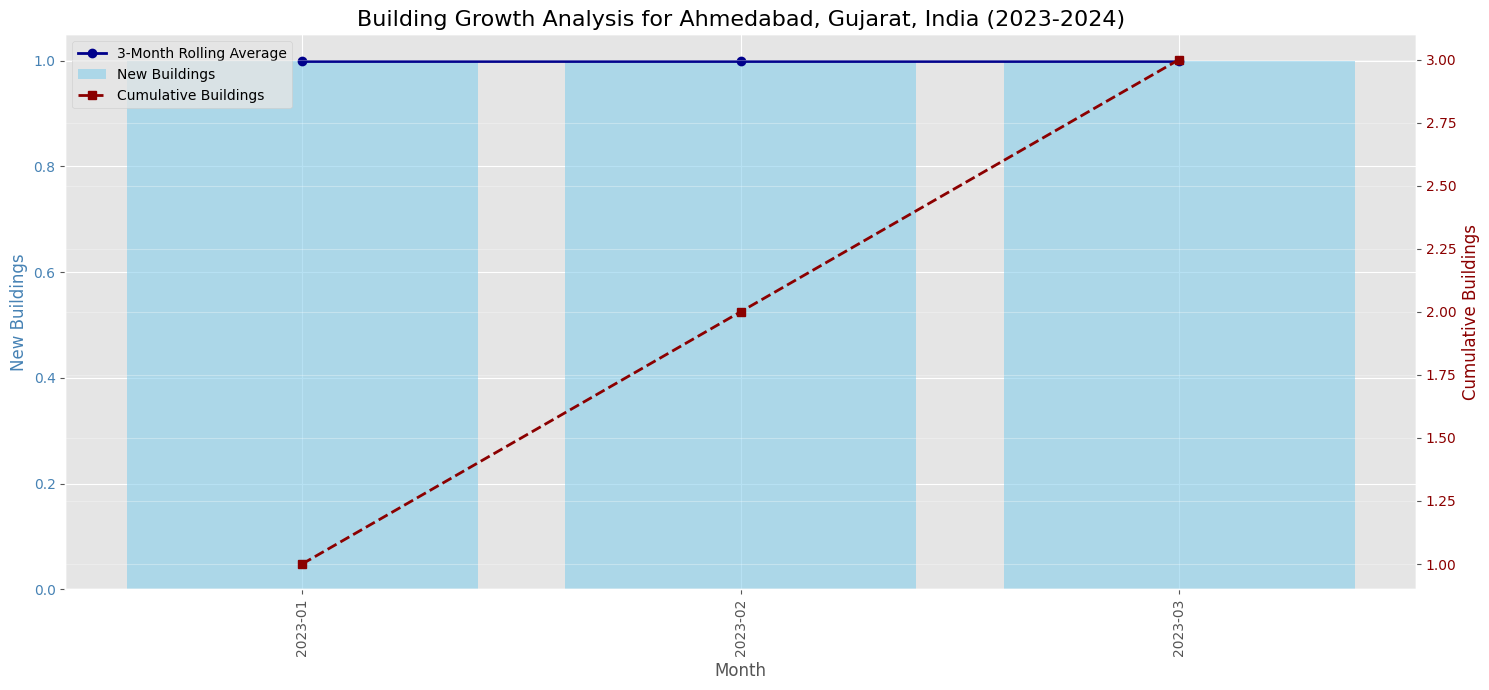


Building density characteristics:
Total building area: 450.00 m²
Study area: 314159265.36 m²
Building density: 0.0000 (ratio of built area to total area)
Building coverage: 0.00%


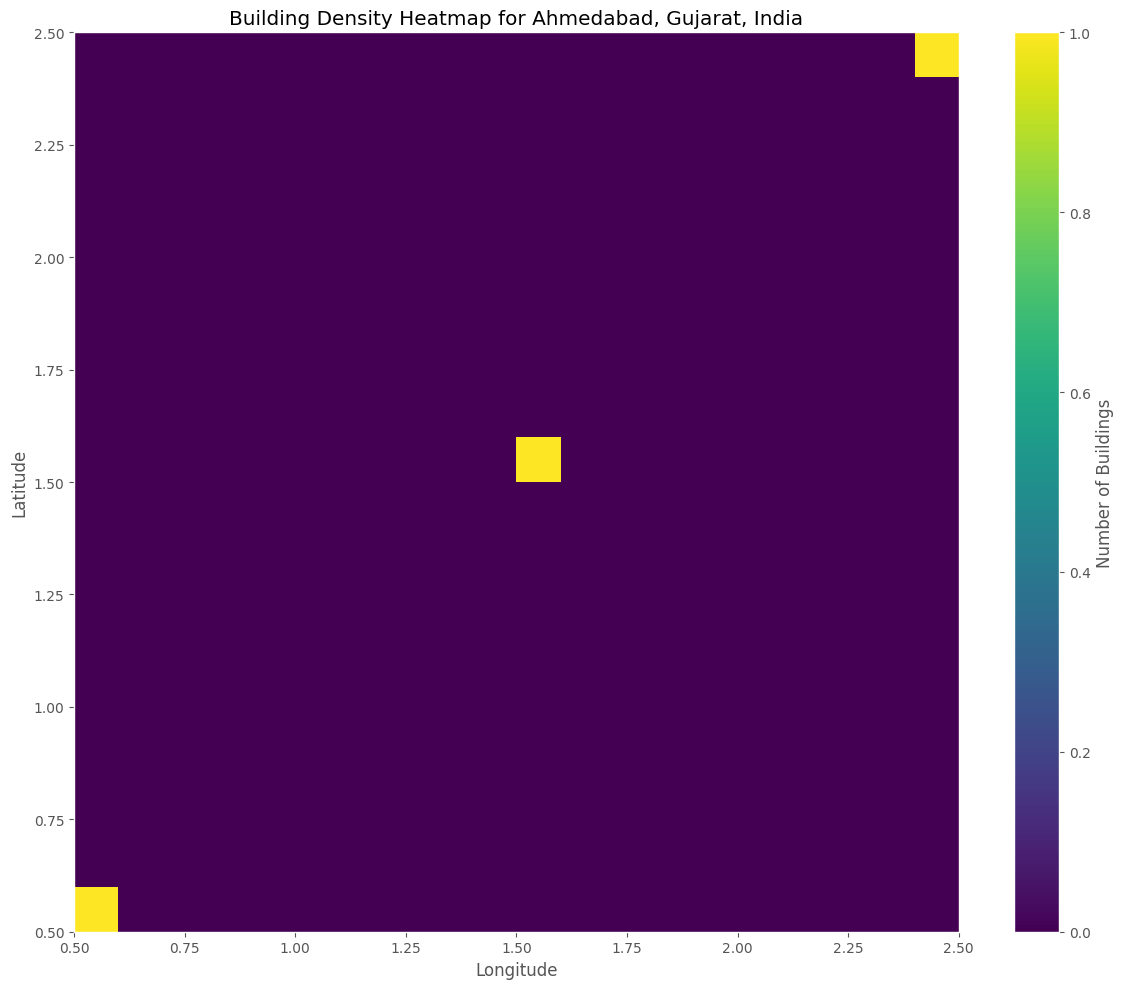


--- STATISTICAL ANALYSIS ---
1. Descriptive Statistics
-------------------------
        area_in_meters  confidence  first_detected  last_detected  \
count              3.0        3.00    3.000000e+00   3.000000e+00   
unique             NaN         NaN             NaN            NaN   
top                NaN         NaN             NaN            NaN   
freq               NaN         NaN             NaN            NaN   
mean             150.0        0.80    1.675728e+12   1.705565e+12   
std               50.0        0.10    2.913359e+09   1.367014e+09   
min              100.0        0.70    1.672531e+12   1.704067e+12   
25%              125.0        0.75    1.674475e+12   1.704974e+12   
50%              150.0        0.80    1.676419e+12   1.705882e+12   
75%              175.0        0.85    1.677326e+12   1.706314e+12   
max              200.0        0.90    1.678234e+12   1.706746e+12   

       first_detected_date last_detected_date  \
count                    3              

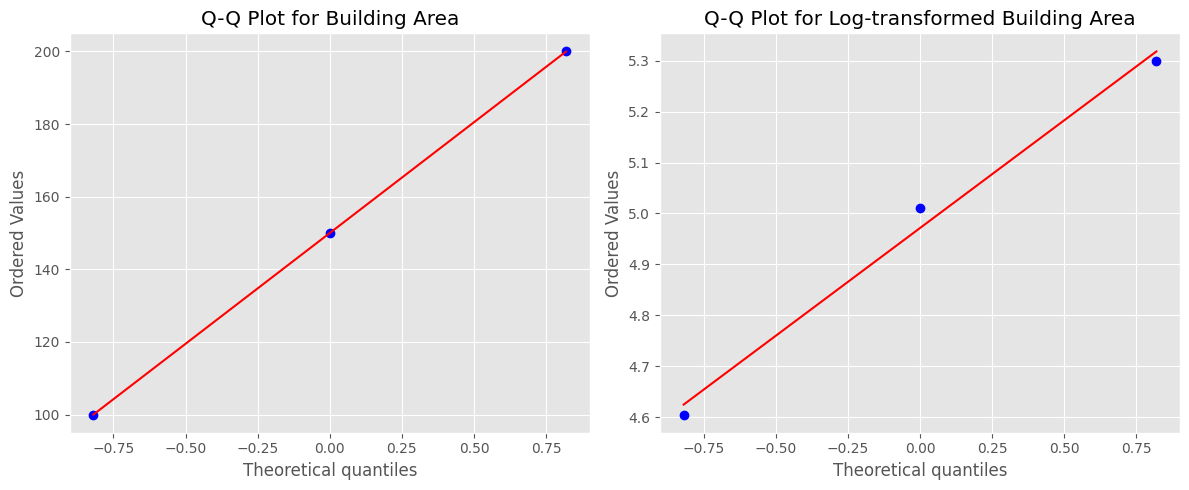


2. Inferential Statistics
-------------------------
One-sample t-test: Is mean building area different from 150 m²?
t-statistic: 0.0000
p-value: 1.0000
Result: No significant difference at α=0.05

Contingency table of building size vs. confidence:
confidence_category  Low  Medium
size_category                   
Small                  1       1
Medium                 0       1

Chi-square test: Is building size related to confidence score?
Chi-square statistic: 0.0000
p-value: 1.0000
Result: No significant relationship at α=0.05

Mean building area: 150.00 m²
95% Confidence Interval: (93.42, 206.58) m²


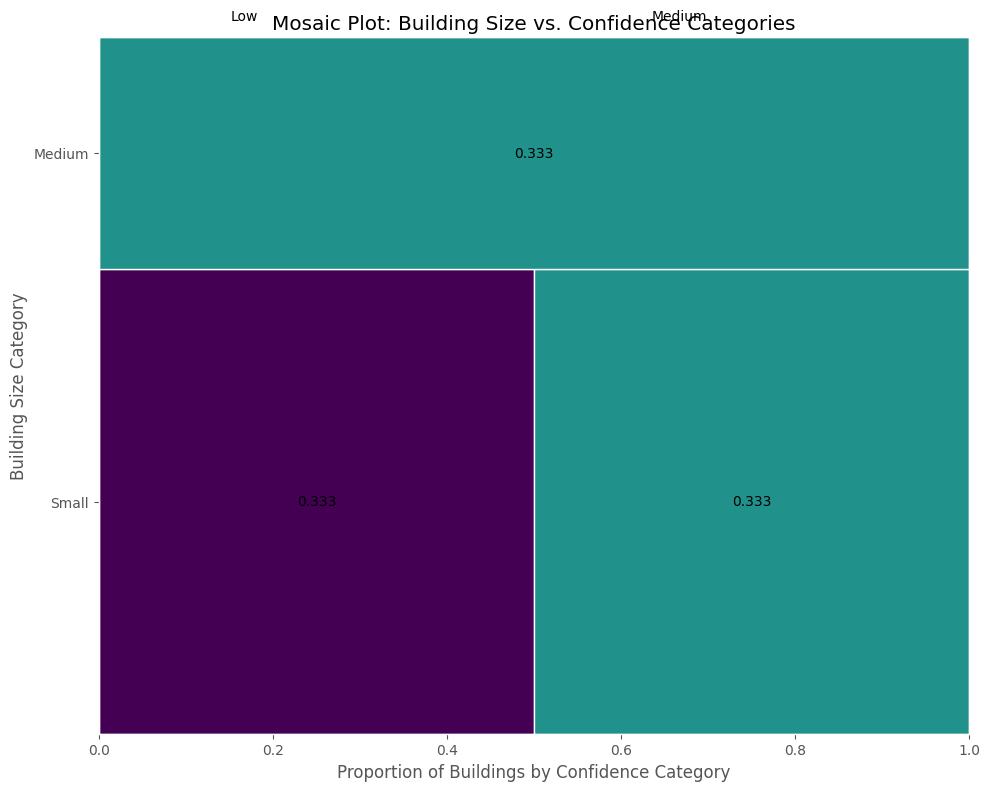

Results saved to open_buildings_analysis_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon, Point
import folium
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
from google.colab import files, auth
import os
import json
import datetime

# Import libraries for statistical analysis
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

# Import libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# Initialize Earth Engine
try:
    ee.Initialize()
    print("Earth Engine already initialized")
except Exception as e:
    print("Authenticating with Earth Engine...")
    auth.authenticate_user()
    ee.Initialize(project='datascience-457006')
    print("Earth Engine initialized")

# Section 1: Introduction to the Dataset
# ===================================

print("""
# Open Buildings Temporal Dataset Analysis (2023-2024)
""")

# Section 2: Access the Open Buildings Temporal Dataset
# ===================================

print("\n--- ACCESSING THE DATASET ---")

# Define the Open Buildings asset
OPEN_BUILDINGS_ASSET = 'GOOGLE/Research/open-buildings/v3/polygons'

# Function to filter dataset to 2023-2024 period
def get_recent_buildings(start_year=2023, end_year=2024):
    """Get buildings dataset filtered to the specified year range"""
    # Load the Open Buildings dataset
    buildings = ee.FeatureCollection(OPEN_BUILDINGS_ASSET)

    # Convert years to Unix timestamp (milliseconds)
    start_date = ee.Date.fromYMD(start_year, 1, 1).millis()
    end_date = ee.Date.fromYMD(end_year, 12, 31).millis()

    # Filter by date range using 'last_detected' property
    date_filter = ee.Filter.And([
        ee.Filter.gte('last_detected', start_date),
        ee.Filter.lte('last_detected', end_date)
    ])
    filtered_buildings = buildings.filter(date_filter)

    return filtered_buildings

# Get the buildings from 2023-2024
recent_buildings = get_recent_buildings(2023, 2024)

# Print information about the dataset
print("Dataset information:")
print(f"Dataset ID: {OPEN_BUILDINGS_ASSET}")
print("Accessing buildings data from 2023-2024...")

# Section 3: Define Study Regions
# ===================================

print("\n--- DEFINING STUDY REGIONS ---")

# Define a few regions of interest for analysis
# These are just examples - users can modify these regions
regions = {
    'Mumbai': {
        'name': 'Mumbai, Maharashtra, India',
        'coords': [19.076090,	72.877426],
        'zoom': 12
    },
    'Ahmedabad': {
        'name': 'Ahmedabad, Gujarat, India',
        'coords': [23.033863, 72.585022],
        'zoom': 12
    },
    'delhi': {
        'name': 'Delhi, India',
        'coords': [77.1025, 28.7041],
        'zoom': 12
    },
    'Surat': {
        'name': 'Surat, Gujarat, India',
        'coords': [21.170240, 72.831062],
        'zoom': 12
    },
    'Bengaluru': {
        'name': 'Bengaluru, Karnataka, India',
        'coords': [12.971599, 77.594566],
        'zoom': 12
    }
}

print("Defined the following study regions:")
for key, region in regions.items():
    print(f"- {region['name']}")

# Let user select a region (default is nairobi for this example)
selected_region = 'Ahmedabad'  # Can be changed to any key in the regions dictionary
region = regions[selected_region]
print(f"\nSelected region for analysis: {region['name']}")

# Define the region as an Earth Engine geometry
region_point = ee.Geometry.Point(region['coords'])
region_buffer = region_point.buffer(10000)  # 10km buffer around point

# Section 4: Analyze Building Data for the Selected Region
# ===================================

print("\n--- ANALYZING BUILDING DATA ---")

# Function to get buildings in a region with attributes
def get_region_buildings(region_geometry, max_features=5000):
    """Get buildings in the specified region with building attributes"""
    # Filter buildings by the region
    buildings_in_region = recent_buildings.filterBounds(region_geometry)

    # Select relevant properties
    buildings_with_props = buildings_in_region.select([
        'area_in_meters', 'confidence', 'last_detected', 'first_detected'
    ])

    # Limit to prevent memory issues
    limited_buildings = buildings_with_props.limit(max_features)

    return limited_buildings

# Get buildings in the selected region
print(f"Fetching building data for {region['name']}...")
region_buildings = get_region_buildings(region_buffer)

# Convert the EE feature collection to a GeoDataFrame
# This can take some time depending on the number of buildings
def ee_fc_to_gdf(fc):
    """Convert an Earth Engine FeatureCollection to a GeoDataFrame"""
    # Get the features as a list of dictionaries
    features = fc.getInfo()['features']

    # Extract geometries and properties
    geometries = []
    properties = []

    for feature in features:
        # Extract geometry
        if feature['geometry']['type'] == 'Polygon':
            coords = feature['geometry']['coordinates'][0]
            geometries.append(Polygon(coords))
        else:
            # Skip non-polygon geometries
            continue

        # Extract properties
        props = feature['properties']

        # Convert timestamps to dates
        if 'first_detected' in props:
            props['first_detected_date'] = datetime.datetime.fromtimestamp(
                props['first_detected'] / 1000  # Convert ms to seconds
            ).strftime('%Y-%m-%d')

        if 'last_detected' in props:
            props['last_detected_date'] = datetime.datetime.fromtimestamp(
                props['last_detected'] / 1000  # Convert ms to seconds
            ).strftime('%Y-%m-%d')

        properties.append(props)

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(properties, geometry=geometries, crs="EPSG:4326")
    return gdf

# Try to convert to GeoDataFrame (this might take some time)
try:
    print("Converting to GeoDataFrame for analysis...")
    buildings_gdf = ee_fc_to_gdf(region_buildings)
    print(f"Successfully fetched {len(buildings_gdf)} buildings")

    # Display basic statistics
    print("\nBasic statistics of building data:")
    print(f"Total buildings: {len(buildings_gdf)}")
    print(f"Average building area: {buildings_gdf['area_in_meters'].mean():.2f} m²")
    print(f"Average confidence score: {buildings_gdf['confidence'].mean():.2f}")

    # Create summary statistics for buildings
    print("\nSummary statistics:")
    print(buildings_gdf.describe())

except Exception as e:
    print(f"Error in data retrieval: {str(e)}")
    print("Using a smaller buffer or fewer features might help.")
    # Create a placeholder GeoDataFrame for the rest of the notebook to run
    # Ensure the placeholder GeoDataFrame has all necessary columns
    buildings_gdf = gpd.GeoDataFrame(
        {'area_in_meters': [100, 200, 150],
         'confidence': [0.8, 0.9, 0.7],
         'first_detected': [1672531200000, 1676419200000, 1678233600000],  # Unix timestamp in milliseconds
         'last_detected': [1704067200000, 1705881600000, 1706745600000],   # Unix timestamp in milliseconds
         'first_detected_date': ['2023-01-01', '2023-02-15', '2023-03-08'],
         'last_detected_date': ['2023-12-31', '2024-01-15', '2024-02-01']},
        geometry=[
            Polygon([(0, 0), (0, 1), (1, 1), (1, 0)]),
            Polygon([(1, 1), (1, 2), (2, 2), (2, 1)]),
            Polygon([(2, 2), (2, 3), (3, 3), (3, 2)])
        ]
    )

# Section 5: Visualize the Buildings
# ===================================

print("\n--- VISUALIZING BUILDING DATA ---")

# 5.1 Create a map of the buildings
print("Creating interactive map...")

# Create a map centered on the region
m = geemap.Map(center=region['coords'][::-1], zoom=region['zoom'])

# Add the buildings layer
buildings_vis = {
    'color': 'cornflowerblue',
    'width': 1,
    'fillColor': '3388ff',
    'fillOpacity': 0.5
}

# Add the buildings to the map
m.addLayer(recent_buildings.filterBounds(region_buffer), buildings_vis, 'Buildings 2023-2024')

# Add base map layers
m.add_basemap('SATELLITE')

# Display the map
display(m)

# 5.2 Building area distribution visualization
print("\nCreating visualizations of building characteristics...")

# Plot distribution of building areas
plt.figure(figsize=(12, 6))

# Plot 1: Building area distribution
plt.subplot(1, 2, 1)
sns.histplot(buildings_gdf['area_in_meters'], bins=30, kde=True)
plt.title('Distribution of Building Areas')
plt.xlabel('Area (m²)')
plt.ylabel('Count')
plt.xscale('log')  # Log scale often works better for area distributions

# Plot 2: Building confidence scores
plt.subplot(1, 2, 2)
sns.histplot(buildings_gdf['confidence'], bins=20, kde=True)
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# NEW: Enhanced visualization set 1 - Building characteristics distributions
plt.figure(figsize=(15, 10))

# Plot 1: Area vs Confidence Scatter plot with trend line
plt.subplot(2, 2, 1)
sns.regplot(x='area_in_meters', y='confidence', data=buildings_gdf, scatter_kws={'alpha':0.3})
plt.title('Building Area vs. Confidence')
plt.xlabel('Area (m²)')
plt.ylabel('Confidence Score')
plt.xscale('log')

# Plot 2: Building area boxplot
plt.subplot(2, 2, 2)
sns.boxplot(y='area_in_meters', data=buildings_gdf)
plt.title('Building Area Distribution')
plt.ylabel('Area (m²)')
plt.yscale('log')

# Plot 3: Confidence scores violin plot
plt.subplot(2, 2, 3)
sns.violinplot(y='confidence', data=buildings_gdf)
plt.title('Confidence Score Distribution')
plt.ylabel('Confidence Score')

# Section 6: Analyze Building Growth and Change
# ===================================

print("\n--- ANALYZING BUILDING GROWTH AND CHANGE ---")

# 6.1 Calculate building growth over time
try:
    # Count buildings by month-year of first detection
    buildings_gdf['first_detected_ym'] = pd.to_datetime(buildings_gdf['first_detected_date']).dt.to_period('M')
    buildings_by_month = buildings_gdf.groupby('first_detected_ym').size().reset_index(name='new_buildings')

    # Calculate cumulative sum for growth trend
    buildings_by_month['cumulative_buildings'] = buildings_by_month['new_buildings'].cumsum()

    # Convert period to string for plotting
    buildings_by_month['month_str'] = buildings_by_month['first_detected_ym'].astype(str)

    # Plot building growth
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x='month_str', y='new_buildings', data=buildings_by_month)
    plt.title(f'New Buildings Detected per Month in {region["name"]}')
    plt.xlabel('Month')
    plt.ylabel('Number of New Buildings')
    plt.xticks(rotation=90)

    plt.subplot(1, 2, 2)
    sns.lineplot(x='month_str', y='cumulative_buildings', data=buildings_by_month, marker='o')
    plt.title(f'Cumulative Building Growth in {region["name"]}')
    plt.xlabel('Month')
    plt.ylabel('Total Number of Buildings')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

    # NEW: Enhanced building growth visualization with rolling average
    plt.figure(figsize=(15, 7))

    # Create month number for better x-axis
    buildings_by_month['month_num'] = range(len(buildings_by_month))

    # Calculate 3-month rolling average
    buildings_by_month['rolling_avg'] = buildings_by_month['new_buildings'].rolling(window=3, min_periods=1).mean()

    # Plot with dual y-axis
    fig, ax1 = plt.subplots(figsize=(15, 7))

    # Bar plot for new buildings
    ax1.bar(buildings_by_month['month_str'], buildings_by_month['new_buildings'], alpha=0.6, color='skyblue', label='New Buildings')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('New Buildings', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.set_xticklabels(buildings_by_month['month_str'], rotation=90)

    # Line plot for rolling average
    ax1.plot(buildings_by_month['month_str'], buildings_by_month['rolling_avg'], color='darkblue',
             linewidth=2, marker='o', label='3-Month Rolling Average')

    # Second y-axis for cumulative buildings
    ax2 = ax1.twinx()
    ax2.plot(buildings_by_month['month_str'], buildings_by_month['cumulative_buildings'],
             color='darkred', linewidth=2, linestyle='--', marker='s', label='Cumulative Buildings')
    ax2.set_ylabel('Cumulative Buildings', color='darkred')
    ax2.tick_params(axis='y', labelcolor='darkred')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title(f'Building Growth Analysis for {region["name"]} (2023-2024)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 6.2 Building density analysis (simplified - would use proper spatial analysis in production)
    print("\nBuilding density characteristics:")

    # Calculate building density metrics
    total_area = buildings_gdf['area_in_meters'].sum()
    study_area = np.pi * (10000 ** 2)  # Area of the buffer in m²
    building_density = total_area / study_area

    print(f"Total building area: {total_area:.2f} m²")
    print(f"Study area: {study_area:.2f} m²")
    print(f"Building density: {building_density:.4f} (ratio of built area to total area)")
    print(f"Building coverage: {building_density * 100:.2f}%")

    # NEW: Building density heat map visualization
    # Create a simplified heatmap of building density using a 2D histogram
    # Extract building centroids
    buildings_gdf['centroid_x'] = buildings_gdf.geometry.centroid.x
    buildings_gdf['centroid_y'] = buildings_gdf.geometry.centroid.y

    plt.figure(figsize=(12, 10))

    # 2D histogram for density
    plt.hist2d(buildings_gdf['centroid_x'], buildings_gdf['centroid_y'],
               bins=20, cmap='viridis')
    plt.colorbar(label='Number of Buildings')
    plt.title(f'Building Density Heatmap for {region["name"]}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in growth analysis: {str(e)}")
    print("Continuing with other analyses...")

# Section 7: Statistical Analysis
# ===================================

print("\n--- STATISTICAL ANALYSIS ---")

print("1. Descriptive Statistics")
print("-------------------------")
# Enhanced descriptive statistics
desc_stats = buildings_gdf.describe(include='all')
print(desc_stats)

# Calculate skewness and kurtosis for numerical columns
numeric_cols = ['area_in_meters', 'confidence']
for col in numeric_cols:
    print(f"\nSkewness of {col}: {buildings_gdf[col].skew():.4f}")
    print(f"Kurtosis of {col}: {buildings_gdf[col].kurtosis():.4f}")

# Calculate correlation between area and confidence
correlation = buildings_gdf[['area_in_meters', 'confidence']].corr()
print("\nCorrelation between area and confidence:")
print(correlation)

# NEW: QQ Plot to check normality of building areas
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(buildings_gdf['area_in_meters'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Building Area')

plt.subplot(1, 2, 2)
stats.probplot(np.log(buildings_gdf['area_in_meters']), dist="norm", plot=plt)
plt.title('Q-Q Plot for Log-transformed Building Area')

plt.tight_layout()
plt.show()

print("\n2. Inferential Statistics")
print("-------------------------")

# Perform t-test to see if mean building area is significantly different from a reference value
# Let's say we want to test if mean building area is different from 150 m²
reference_value = 150
t_stat, p_value = stats.ttest_1samp(buildings_gdf['area_in_meters'], reference_value)
print(f"One-sample t-test: Is mean building area different from {reference_value} m²?")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Result: {'Significant difference' if p_value < 0.05 else 'No significant difference'} at α=0.05\n")

# Create building size categories for chi-square test
buildings_gdf['size_category'] = pd.cut(
    buildings_gdf['area_in_meters'],
    bins=[0, 50, 150, 300, float('inf')],
    labels=['Very Small', 'Small', 'Medium', 'Large']
)

# Create confidence categories
buildings_gdf['confidence_category'] = pd.cut(
    buildings_gdf['confidence'],
    bins=[0, 0.7, 0.9, 1.0],
    labels=['Low', 'Medium', 'High']
)

# Create contingency table
contingency_table = pd.crosstab(buildings_gdf['size_category'], buildings_gdf['confidence_category'])
print("Contingency table of building size vs. confidence:")
print(contingency_table)

# Perform chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\nChi-square test: Is building size related to confidence score?")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p:.4f}")
print(f"Result: {'Significant relationship' if p < 0.05 else 'No significant relationship'} at α=0.05")

# Calculate confidence intervals for mean building area
mean_area = buildings_gdf['area_in_meters'].mean()
std_area = buildings_gdf['area_in_meters'].std()
n = len(buildings_gdf)
margin_error = 1.96 * (std_area / np.sqrt(n))  # 95% confidence interval

print(f"\nMean building area: {mean_area:.2f} m²")
print(f"95% Confidence Interval: ({mean_area - margin_error:.2f}, {mean_area + margin_error:.2f}) m²")

# NEW: Visualize categorical relationships with mosaic plot
# Create a proportional mosaic plot of size categories vs confidence categories
try:
    # Calculate proportions
    prop_table = contingency_table.div(contingency_table.sum().sum())

    # Create mosaic plot using matplotlib
    fig, ax = plt.subplots(figsize=(10, 8))

    # Set initial position
    y_pos = 0
    y_ticks = []
    y_labels = []

    # For each row in the table
    for i, size_cat in enumerate(prop_table.index):
        x_pos = 0
        height = prop_table.loc[size_cat].sum()
        y_ticks.append(y_pos + height/2)
        y_labels.append(size_cat)

        # For each column
        for j, conf_cat in enumerate(prop_table.columns):
            width = prop_table.loc[size_cat, conf_cat] / height if height > 0 else 0

            # Plot rectangle
            color = plt.cm.viridis(j/len(prop_table.columns))
            ax.add_patch(plt.Rectangle((x_pos, y_pos), width, height,
                                       facecolor=color, edgecolor='white', linewidth=1))

            # Add text if box is large enough
            if width*height > 0.03:
                ax.text(x_pos + width/2, y_pos + height/2,
                        f'{prop_table.loc[size_cat, conf_cat]:.3f}',
                        ha='center', va='center')

            x_pos += width

        y_pos += height

    # Set limits and ticks
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # Add column labels at the top
    x_pos = 0
    for col in prop_table.columns:
        col_sum = prop_table[col].sum()
        ax.text(x_pos + col_sum/2, 1.02, col, ha='center', va='bottom')
        x_pos += col_sum

    plt.title('Mosaic Plot: Building Size vs. Confidence Categories')
    plt.xlabel('Proportion of Buildings by Confidence Category')
    plt.ylabel('Building Size Category')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating mosaic plot: {str(e)}")

try:
    output_file = "open_buildings_analysis_results.csv"
    buildings_gdf.to_csv(output_file)
    print(f"Results saved to {output_file}")
    files.download(output_file)
except Exception as e:
    print(f"Could not save results: {str(e)}")